In [1]:
#Core Libraries
import os
import glob
import numpy as np
import pickle

#Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

#PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

#Utilities
from tqdm import tqdm
from tqdm import trange
from sklearn.model_selection import train_test_split


In [2]:
# load vertex data and expression basis
vertex_sequences = np.load('/home/s5722127/MasterClass/traineddata/data_verts.npy')
expression_basis = np.load('/home/s5722127/MasterClass/traineddata/init_expression_basis.npy')

# flatten vertex data and project into expression space
flat_vertices = vertex_sequences.reshape(-1, 15069)
transformed_output = flat_vertices @ expression_basis
transformed_output.shape


(123341, 100)

In [4]:
# load deepspeech audio features and index mapping
with open('/home/s5722127/MasterClass/traineddata/processed_audio_deepspeech.pkl', 'rb') as af:
    deepspeech_data = pickle.load(af, encoding='latin1')

with open('/home/s5722127/MasterClass/traineddata/subj_seq_to_idx.pkl', 'rb') as sf:
    index_map = pickle.load(sf, encoding='latin1')

# show loaded subject names
if isinstance(deepspeech_data, dict):
    print("subjects:", list(deepspeech_data.keys()))

# check structure of a sample sentence
sample_sentence = deepspeech_data['FaceTalk_170904_00128_TA']['sentence03']
for key, val in sample_sentence.items():
    print(f"key: {key}")
    match val:
        case np.ndarray():
            print(f"array, shape: {val.shape}, dtype: {val.dtype}")
        case list():
            print(f"list, length: {len(val)}")
        case _:
            print(f"type: {type(val).__name__}")

subjects: ['FaceTalk_170904_00128_TA', 'FaceTalk_170811_03275_TA', 'FaceTalk_170725_00137_TA', 'FaceTalk_170811_03274_TA', 'FaceTalk_170915_00223_TA', 'FaceTalk_170912_03278_TA', 'FaceTalk_170809_00138_TA', 'FaceTalk_170908_03277_TA', 'FaceTalk_170728_03272_TA', 'FaceTalk_170913_03279_TA', 'FaceTalk_170731_00024_TA', 'FaceTalk_170904_03276_TA']
key: audio
array, shape: (358, 16, 29), dtype: float64
key: sample_rate
type: int


In [5]:
# define subject and sentence to inspect
target_subject = 'FaceTalk_170904_00128_TA'
target_sentence = 'sentence29'

# get frame-to-index mapping and sort
frame_map = index_map[target_subject][target_sentence]
ordered_frame_ids = [frame_map[i] for i in sorted(frame_map)]

# retrieve expression features using sorted frame indices
expression_features = transformed_output[ordered_frame_ids]  # (num_frames, 100)

# access corresponding audio features
audio_entry = deepspeech_data[target_subject][target_sentence]
print(f"audio keys: {list(audio_entry.keys())}")

# extract mel spectrogram features
mel_features = audio_entry['audio']
print(f"expression shape: {expression_features.shape}")
print(f"mel shape: {mel_features.shape}")

audio keys: ['audio', 'sample_rate']
expression shape: (340, 100)
mel shape: (340, 16, 29)


In [6]:
# prepare aligned audio and expression data
audio_samples = []
expression_targets = []
sequence_labels = []  # store subject and sentence ids

for subj in index_map:
    if subj not in deepspeech_data:
        continue

    for sent in index_map[subj]:
        if sent not in deepspeech_data[subj]:
            continue

        # get expression and audio features
        frame_ids = index_map[subj][sent]
        ordered_idxs = [frame_ids[i] for i in sorted(frame_ids)]
        expr_features = transformed_output[ordered_idxs]
        audio_feat = deepspeech_data[subj][sent]['audio']

        # trim to same length
        limit = min(len(expr_features), len(audio_feat))
        expr_features = expr_features[:limit]
        audio_feat = audio_feat[:limit]

        # store results
        audio_samples.append(audio_feat)
        expression_targets.append(expr_features)
        sequence_labels.append(f"{subj}_{sent}")

print(f"total aligned sequences: {len(audio_samples)}")
print(f"example: {audio_samples[0].shape}, {expression_targets[0].shape}, id: {sequence_labels[0]}")


total aligned sequences: 473
example: (203, 16, 29), (203, 100), id: FaceTalk_170904_00128_TA_sentence37


In [7]:
# reshape and project mesh vertices to expression space
flattened_verts = vertex_sequences.reshape(-1, 5023 * 3)           
expression_features = flattened_verts @ expression_basis           

paired_audio = []
paired_expr = []

# align audio features and expression features by frame
for subject_id in index_map:
    if subject_id not in deepspeech_data:
        continue
    for sentence_id in index_map[subject_id]:
        if sentence_id not in deepspeech_data[subject_id]:
            continue

        frame_map = index_map[subject_id][sentence_id]
        sorted_indices = [frame_map[i] for i in sorted(frame_map)]

        expr_seq = expression_features[sorted_indices]                                     
        audio_seq = deepspeech_data[subject_id][sentence_id]['audio']                      
        audio_seq = audio_seq.reshape(len(audio_seq), -1)                                  

        min_len = min(len(expr_seq), len(audio_seq))
        paired_audio.append(audio_seq[:min_len])
        paired_expr.append(expr_seq[:min_len])

# normalize audio and expression data
all_audio = np.concatenate(paired_audio, axis=0)
all_expr = np.concatenate(paired_expr, axis=0)

audio_mean = all_audio.mean(axis=0)
audio_std = all_audio.std(axis=0) + 1e-5
expr_mean = all_expr.mean(axis=0)
expr_std = all_expr.std(axis=0) + 1e-5

norm_audio = [(a - audio_mean) / audio_std for a in paired_audio]
norm_expr = [(e - expr_mean) / expr_std for e in paired_expr]

# save normalized data
output = {
    'audio': norm_audio,
    'expression': norm_expr,
    'audio_mean': audio_mean,
    'audio_std': audio_std,
    'expr_mean': expr_mean,
    'expr_std': expr_std
}

with open("normalized_data.pkl", "wb") as f:
    pickle.dump(output, f)

print("normalized data saved to normalized_data.pkl")


normalized data saved to normalized_data.pkl


In [8]:
# define dataset class using sliding window
class MyDataset(Dataset):
    def __init__(self, mel_sequences, expression_sequences, window_size=120, stride=120):
        self.samples = []
        for mel, expr in zip(mel_sequences, expression_sequences):
            max_len = min(len(mel), len(expr))
            for start in range(0, max_len - window_size + 1, stride):
                mel_segment = torch.tensor(mel[start:start+window_size], dtype=torch.float32)
                expr_segment = torch.tensor(expr[start:start+window_size], dtype=torch.float32)
                self.samples.append((mel_segment, expr_segment))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return self.samples[index]

# load normalized audio and expression data
with open("normalized_data.pkl", "rb") as f:
    data = pickle.load(f)

audio_samples = data['audio']
expression_targets = data['expression']

# split into train, validation, test sets
audio_train, audio_temp, expr_train, expr_temp = train_test_split(
    audio_samples, expression_targets, test_size=0.2, random_state=42
)
audio_val, audio_test, expr_val, expr_test = train_test_split(
    audio_temp, expr_temp, test_size=0.5, random_state=42
)

# build datasets with sliding window
train_dataset = MyDataset(audio_train, expr_train, window_size=120, stride=120)
val_dataset   = MyDataset(audio_val, expr_val, window_size=120, stride=120)
test_dataset  = MyDataset(audio_test, expr_test, window_size=120, stride=120)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"train: {len(train_dataset)} | val: {len(val_dataset)} | test: {len(test_dataset)}")


train: 612 | val: 83 | test: 79


In [9]:
# transformer model that maps mel spectrograms to expression features
class AudioToExpressionTransformer(nn.Module):
    def __init__(self, 
                 input_dim=464, output_dim=100, hidden_dim=128, 
                 num_heads=8, num_layers=3, dropout=0.2, max_seq_len=120):
        super().__init__()

        # linear projection for input features
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # learnable positional encoding
        self.positional_embedding = nn.Parameter(
            torch.randn(1, max_seq_len, hidden_dim)
        )

        # normalization layer
        self.norm = nn.LayerNorm(hidden_dim)

        # transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # projection to output expression space
        self.output_proj = nn.Linear(hidden_dim, output_dim)

    def forward(self, mel_input):
        # support both [B, T, 16, 29] and [B, T, 464] formats
        if mel_input.ndim == 4:
            B, T, C, F = mel_input.shape
            mel_input = mel_input.view(B, T, C * F)
        elif mel_input.ndim != 3:
            raise ValueError(f"expected 3D or 4D tensor, got {mel_input.shape}")

        B, T, _ = mel_input.shape

        # apply input projection, position encoding, and transformer
        x = self.input_proj(mel_input)
        x = x + self.positional_embedding[:, :T, :]
        x = self.norm(x)
        x = self.encoder(x)
        output = self.output_proj(x)
        return output


[Epoch 100/100] Train: 0.7224 | Val: 0.7511: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


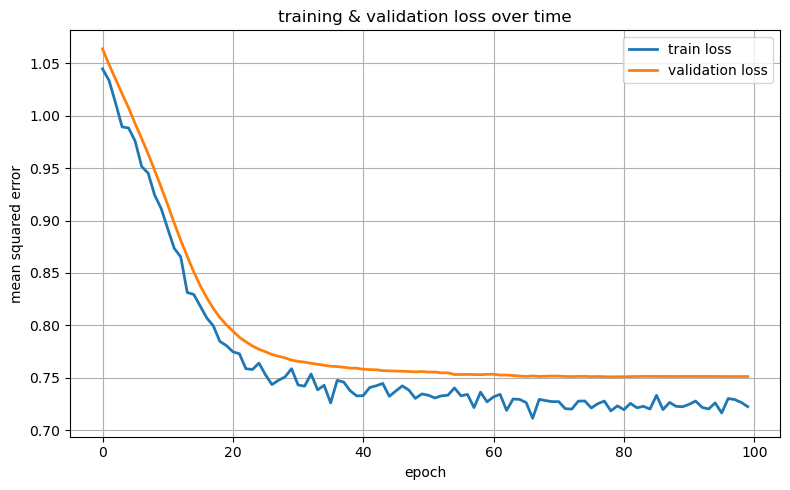

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# setup model and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AudioToExpressionTransformer(max_seq_len=120).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# training settings
num_epochs = 100
patience = 100
best_val = float('inf')
wait = 0

train_losses = []
val_losses = []

# progress bar for epochs
epoch_bar = trange(num_epochs, desc="Training", leave=True)

for epoch in epoch_bar:
    model.train()
    train_loss = 0.0

    for mel_batch, expr_batch in train_loader:
        mel_batch = mel_batch.to(device)
        expr_batch = expr_batch.to(device)

        optimizer.zero_grad()
        output = model(mel_batch)
        loss = ((output - expr_batch) ** 2).mean()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mel_batch, expr_batch in val_loader:
            mel_batch = mel_batch.to(device)
            expr_batch = expr_batch.to(device)
            output = model(mel_batch)
            loss = ((output - expr_batch) ** 2).mean()
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    # update progress bar
    epoch_bar.set_description(f"[Epoch {epoch+1}/{num_epochs}] Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    # save best model
    if avg_val_loss < best_val:
        best_val = avg_val_loss
        wait = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            epoch_bar.write(f"early stopping at epoch {epoch+1}: no improvement for {patience} epochs")
            break

# plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='train loss', linewidth=2)
plt.plot(val_losses, label='validation loss', linewidth=2)
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.title('training & validation loss over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# load best model
model = AudioToExpressionTransformer(max_seq_len=120)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# evaluate on test set and save predicted + ground truth expression features
def evaluate_model(model, test_loader, device='cuda', save_dir='output_expr'):
    import os
    os.makedirs(save_dir, exist_ok=True)

    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []
    total_loss = 0.0

    with torch.no_grad():
        for audio_batch, expr_batch in test_loader:
            audio_batch = audio_batch.to(device)
            expr_batch = expr_batch.to(device)

            predictions = model(audio_batch)
            loss = ((predictions - expr_batch) ** 2).mean()
            total_loss += loss.item()
            all_preds.append(predictions.cpu())
            all_targets.append(expr_batch.cpu())

    avg_loss = total_loss / len(test_loader)

    pred_all = torch.cat(all_preds).numpy()           # all predicted frames
    target_all = torch.cat(all_targets).numpy()       # all ground truth frames

    np.save(f"{save_dir}/predicted_expr.npy", pred_all)
    np.save(f"{save_dir}/groundtruth_expr.npy", target_all)

    return avg_loss

# run evaluation and save results
evaluate_model(model, test_loader, device='cuda')


/tmp/ipykernel_5302/845178546.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


0.7994836568832397

In [12]:
# load predicted expression parameters
predicted_expr = np.load("output_expr/predicted_expr.npy")      
sample_expr = predicted_expr[1]                                  

# load expression basis matrix
basis = np.load('/home/s5722127/MasterClass/traineddata/init_expression_basis.npy')  

# load subject-specific neutral mesh
with open('/home/s5722127/MasterClass/traineddata/templates.pkl', 'rb') as f:
    templates = pickle.load(f, encoding='latin1')

# specify subject
subject_id = "FaceTalk_170904_00128_TA"
template = templates[subject_id]                                 

# reconstruct mesh sequence from expression coefficients
mesh_frames = []
for i in range(len(sample_expr)):                                
    expr_vec = sample_expr[i]                                    
    offset = (basis @ expr_vec).reshape(5023, 3)                 
    mesh = template + offset                                     
    mesh_frames.append(mesh)

# print mesh sequence info
print(f"Total frames: {len(mesh_frames)}")
print(f"Mesh shape (1st frame): {mesh_frames[0].shape}")  


Total frames: 120
Mesh shape (1st frame): (5023, 3)


In [13]:
# load ground truth expressions
groundtruth_expr = np.load("output_expr/groundtruth_expr.npy")  # shape: (samples, 120, 100)

# load expression basis
basis = np.load('/home/s5722127/MasterClass/traineddata/init_expression_basis.npy')

# load template mesh
with open('/home/s5722127/MasterClass/traineddata/templates.pkl', 'rb') as f:
    templates = pickle.load(f, encoding='latin1')

# choose subject template
template = templates['FaceTalk_170904_00128_TA']


In [14]:
def comparison(gt_verts, pred_verts, frame_idx=0):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    for ax, verts, title in zip(
        axs, [gt_verts, pred_verts], ["ground truth", "prediction"]
    ):
        ax.set_title(f"{title}")
        ax.set_xlim(-0.1, 0.1)
        ax.set_ylim(-0.1, 0.1)
        ax.set_aspect("equal")
        ax.axis("off")

        ax.scatter(verts[:, 0], verts[:, 1], s=1, c='blue')

    plt.tight_layout()
    plt.show()


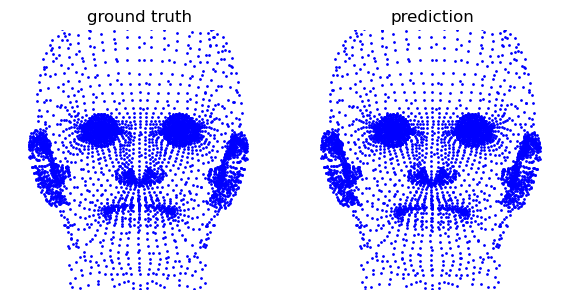

In [18]:
frame_idx = 1
gt_expr = groundtruth_expr[1][frame_idx]
gt_offset = (basis @ gt_expr).reshape(5023, 3)
gt_mesh = template + gt_offset

pred_mesh = mesh_frames[frame_idx]

comparison(gt_mesh, pred_mesh, frame_idx=frame_idx)

In [21]:

def animate(mesh_sequence, num_frames=100, interval=100, zoom=1.0):
    verts = np.array(mesh_sequence[:num_frames]) * zoom  # Scale for visibility

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter([], [], [], s=1)

    # Automatically set axis limits from entire sequence
    xlim = (np.min(verts[:, :, 0]), np.max(verts[:, :, 0]))
    ylim = (np.min(verts[:, :, 1]), np.max(verts[:, :, 1]))
    zlim = (np.min(verts[:, :, 2]), np.max(verts[:, :, 2]))

    def init():
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        ax.view_init(elev=90, azim=-90)
        return scatter,

    def update(frame_idx):
        frame = verts[frame_idx]
        scatter._offsets3d = (frame[:, 0], frame[:, 1], frame[:, 2])
        ax.set_title(f"Frame {frame_idx}")
        return scatter,

    ani = animation.FuncAnimation(# Learnable positional embedding
        fig, update,
        frames=len(verts),
        init_func=init,
        interval=interval,
        blit=False
    )

    plt.close()
    return HTML(ani.to_html5_video())

# Run animation
animate(mesh_frames, num_frames=100, zoom=100)
